In [1]:
%%time
dataset_name = "W19_only"
df_list = []

%matplotlib inline 
%run f2f_header.py {dataset_name} {df_list}
# (var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)    
# get full set of inferred "cross wave" auth-lib/left-right values and ages
# pan_dataset_allr_values = pd.read_pickle(BES_small_data_files + "pan_dataset_allr_valuesW19"+".zip",compression='zip')
# # pan_dataset_allr_values = pan_dataset_allr_values.loc[BES_Panel.index].sort_index()
# pan_dataset_ages = pd.read_pickle(BES_small_data_files + "pan_dataset_ages"+".zip", compression='zip')
# pan_dataset_votes = pd.read_pickle(BES_small_data_files+"pan_dataset_votes"+".zip",compression='zip')
# del BES_Panel

Toggle code

Wall time: 33.9 s


In [2]:
BES_df_list = pickle.load( open( "E:\\BES_analysis_data\\Face_to_face\\BES_df_list.pickle", "rb" ) )
f2f_harmonised = pd.read_pickle("E:\\BES_analysis_data\\Face_to_face\\f2f_harmonised.zip", compression='zip')
BES_label_list = pickle.load( open( "E:\\BES_analysis_data\\Face_to_face\\BES_label_list.pickle", "rb" ) )
demo_var_dict = pickle.load( open( "E:\\BES_analysis_data\\Face_to_face\\demo_var_dict.pickle", "rb" ) )
var_type_dict_nonans = pickle.load( open( "E:\\BES_analysis_data\\Face_to_face\\var_type_dict_nonans.pickle", "rb" ) )

In [ ]:
## BUGS!

var_type_dict_nonans["1997"]['vote_bes']="nominal"

In [28]:


def full_form_birth_year(x):
    if pd.isnull(x):
        return np.nan
    elif x>60:
        return 1800 + x
    else:
        return 1900 + x
    
def rep_char(x):
    return x.replace('[', '{').replace(']', '}').replace('<', '{').replace('>', '}')

def replace_var_names(labels):
    varname_replace_dict = {}
    replace_char_dict = {"[":"{","]":"}"}
    for col in df_simp.columns:
        if np.any([x in col for x in generic_cols]) or (col =="Age"):
            # 'age' is a problem as a common word component
            varname_replace_dict[col] = rep_char(col)
            
        elif "|" not in col:
            varname_replace_dict[col] = rep_char(labels[col])
        elif len(col.split("|"))==2:
            varname_replace_dict[col] = rep_char(labels[col.split("|")[0]])\
                +"("+ rep_char(col.split("|")[1]) +")"
        if varname_replace_dict[col]=="":
            varname_replace_dict[col] = rep_char(col)
    return varname_replace_dict

def rep_char(x):
    return x.replace('[', '{').replace(']', '}').replace('<', '{').replace('>', '}')

def replace_var_names(labels,df_simp):
    varname_replace_dict = {}
    replace_char_dict = {"[":"{","]":"}"}
    for col in df_simp.columns:
        if np.any([x in col for x in generic_cols]) or (col =="Age"):
            # 'age' is a problem as a common word component
            varname_replace_dict[col] = rep_char(col)
            
        elif "|" not in col:
            varname_replace_dict[col] = rep_char(labels[col])
        elif len(col.split("|"))==2:
            varname_replace_dict[col] = rep_char(labels[col.split("|")[0]])\
                +"("+ rep_char(col.split("|")[1]) +")"
        if varname_replace_dict[col]=="":
            varname_replace_dict[col] = rep_char(col)
    return varname_replace_dict

def prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=False,drop_vars = [],demo_var_only=True,
        multi_class_target=False,dummy_na=True,specific_vars = False):

    if demo_var_only:
        demo_vars = demo_var_dict[ge]
    elif specific_vars:
        demo_vars = specific_vars
    else:
        demo_vars = list(BES_label_list[ge].keys())

#     labels = BES_label_list[ge]
    df = pd.concat([BES_df_list[ge],
                            f2f_harmonised[f2f_harmonised["dataset"]==ge][harm_vars]
                           ],axis=1)
    old_demo_vars = demo_vars.copy()
    demo_vars = demo_vars+harm_vars
    demo_vars = list(set(demo_vars).intersection(df.columns))
    if drop_vars:
        demo_vars = [x for x in demo_vars if x not in drop_vars]
        old_demo_vars = [x for x in old_demo_vars if x not in drop_vars]    

    df_simp = df[demo_vars].copy()

    df_simp[target_var] = df_simp[target_var].replace(target_var_replace_dict)
    # prep nominal and ordinal as categorical to be dummied
    old_demo_vars = [x for x in old_demo_vars if var_type_dict_nonans[ge][x] in ["nominal","ordinal"]]
    scale_vars = [x for x in old_demo_vars if var_type_dict_nonans[ge][x] in ["scale"]]
        
    if not multi_class_target:
        df_simp[target_var] = df_simp[target_var].replace(target_var_replace_dict)    
        df_simp[old_demo_vars] = df_simp[old_demo_vars].astype('category')    
        df_simp[scale_vars] = df_simp[scale_vars].astype('float')
        df_simp = pd.get_dummies(df_simp,prefix_sep='|',dummy_na=dummy_na).drop(target_var_drop_list,axis=1)
        if target_var+"|nan" in df_simp.columns:
            df_simp.loc[df_simp[target_var+"|nan"]==1,var_stub]=np.nan
            df_simp.drop(target_var+"|nan",axis=1,inplace=True,)
    else:
        old_demo_vars = [x for x in old_demo_vars if x !=target_var]
        scale_vars = [x for x in scale_vars if x !=target_var]   
        df_simp[old_demo_vars] = df_simp[old_demo_vars].astype('category')    
        df_simp[scale_vars] = df_simp[scale_vars].astype('float')        
        df_simp[target_var] = df_simp[target_var].astype('category')
        target_var_drop_list = [x for x in target_var_drop_list if x in df_simp[target_var].cat.categories]
        df_simp[target_var] = df_simp[target_var].cat.remove_categories(target_var_drop_list)        
        all_but_target = [x for x in df_simp.columns if x !=target_var]
        target_temp = df_simp[target_var].copy()
        df_simp = pd.get_dummies(df_simp[all_but_target],prefix_sep='|',dummy_na=dummy_na)
        df_simp[target_temp.name] = target_temp
        

    df_simp = df_simp.rename(columns = replace_var_names( BES_label_list[ge] , df_simp ))  
    

    Treatment = var_stub+"_"+ge

    var_list = [var_stub]
    var_stub_list = [var_stub,]
    if not multi_class_target:
        df_simp = df_simp.select_dtypes('number')
        df_simp = df_simp.astype('float')
#     mask = df_simp[var_stub].notnull() & df_simp["wt"].notnull()
    return df_simp

def prep_df(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=False,drop_vars = [],demo_var_only=True,alg=None,
           multi_class_target=False,dummy_na=True,specific_vars = False):

    # drop drop_var variables from demo_var list
    if demo_var_only:
        demo_vars = demo_var_dict[ge]
    elif specific_vars:
        demo_vars = specific_vars
    else:
        demo_vars = list(BES_label_list[ge].keys())
        

#     labels = BES_label_list[ge]
    df = pd.concat([BES_df_list[ge],
                            f2f_harmonised[f2f_harmonised["dataset"]==ge][harm_vars]
                           ],axis=1)

    
    old_demo_vars = demo_vars.copy()
    demo_vars = demo_vars+harm_vars
    demo_vars = list(set(demo_vars).intersection(df.columns))
    # drop vars after adding harm/dropping ones not present
    if drop_vars:
        demo_vars = [x for x in demo_vars if x not in drop_vars]    
        old_demo_vars = [x for x in old_demo_vars if x not in drop_vars]    

    df_simp = df[demo_vars].copy()



    # prep nominal and ordinal as categorical to be dummied
    old_demo_vars = [x for x in old_demo_vars if var_type_dict_nonans[ge][x] in ["nominal","ordinal"]]
    scale_vars = [x for x in old_demo_vars if var_type_dict_nonans[ge][x] in ["scale"]]
    
    if not multi_class_target:
        df_simp[target_var] = df_simp[target_var].replace(target_var_replace_dict)    
        df_simp[old_demo_vars] = df_simp[old_demo_vars].astype('category')    
        df_simp[scale_vars] = df_simp[scale_vars].astype('float')
        df_simp = pd.get_dummies(df_simp,prefix_sep='|',dummy_na=dummy_na).drop(target_var_drop_list,axis=1)
        if target_var+"|nan" in df_simp.columns:
            df_simp.loc[df_simp[target_var+"|nan"]==1,var_stub]=np.nan
            df_simp.drop(target_var+"|nan",axis=1,inplace=True,)
        eval_metric='rmse'
    else:
        old_demo_vars = [x for x in old_demo_vars if x !=target_var]
        scale_vars = [x for x in scale_vars if x !=target_var]
        df_simp[old_demo_vars] = df_simp[old_demo_vars].astype('category')    
        df_simp[scale_vars] = df_simp[scale_vars].astype('float')
        df_simp[target_var] = df_simp[target_var].astype('category')
        target_var_drop_list = [x for x in target_var_drop_list if x in df_simp[target_var].cat.categories]
        df_simp[target_var] = df_simp[target_var].cat.remove_categories(target_var_drop_list)
        all_but_target = [x for x in df_simp.columns if x !=target_var]
        target_temp = df_simp[target_var].copy()
        df_simp = pd.get_dummies(df_simp[all_but_target],prefix_sep='|',dummy_na=dummy_na)
        df_simp[target_temp.name] = target_temp
        eval_metric='mlogloss'
    
    df_simp = df_simp.rename(columns = replace_var_names( BES_label_list[ge] , df_simp ))  
    

    Treatment = var_stub+"_"+ge

    var_list = [var_stub]
    var_stub_list = [var_stub,]
    
    if not multi_class_target:
        df_simp = df_simp.select_dtypes('number')
        df_simp = df_simp.astype('float')
        
    mask = df_simp[var_stub].notnull() & df_simp["wt"].notnull()
    colname = var_stub
    if target_var_title_pair is not None:
        title = "\n\nMore Likely to "+target_var_title_pair[0]+" <---   ---> More Likely to"+target_var_title_pair[1]
    else:
        title = ""
    (explainer, shap_values, train_columns, train_index, alg,output_subfolder)=\
        xgboost_run(subdir=colname,dataset=df_simp[mask].drop("wt",axis=1),
                var_list=var_list,var_stub_list=var_stub_list,
                use_specific_weights=df_simp["wt"][mask],
                min_features = min(df_simp.shape[1]-1,min_features),verbosity=0,
                skip_bar_plot=True,dependence_plots=dependence_plots,alg=alg,eval_metric=eval_metric,                    
                title = title)
    
    return (explainer, shap_values, train_columns, train_index, alg,output_subfolder)

In [4]:
ge = "1970"
{k:v for k,v in BES_label_list[ge].items() if "SEX" in v}

{'v929': 'SEX                 1963',
 'v930': 'SEX                 1964',
 'v931': 'SEX                 1966',
 'v932': 'SEX                 1970'}

In [7]:
BES_df_list["1970"][["v929","v930","v931","v932",]].stack().value_counts()

0.0    4414
2.0    3907
1.0    3367
dtype: int64

In [18]:
df = BES_df_list["1970"][["v929","v930","v931","v932",]]

ana_trans = df.replace(0,np.nan).apply(lambda x: len(pd.unique(x.dropna())),axis=1)[df.replace(0,np.nan).apply(lambda x: len(pd.unique(x.dropna())),axis=1)==2].index
# = df.replace(0,np.nan).apply(lambda x: len(pd.unique(x.dropna())),axis=1)[df.replace(0,np.nan).apply(lambda x: len(pd.unique(x.dropna())),axis=1)!=2].index

# 0: 1: male, 2: female, 

In [61]:
gender = df.replace(0,np.nan).fillna(method='ffill',axis=1)['v932']
gender.loc[ana_trans] = np.nan
gender = gender-1
gender.value_counts()

# male = 0, female = 1

1.0    1557
0.0    1331
Name: v932, dtype: int64

In [19]:
df.loc[ana_trans]

,v929,v930,v931,v932
60,0.0,1.0,2.0,0.0
105,1.0,0.0,0.0,2.0
408,2.0,2.0,2.0,1.0
464,2.0,0.0,1.0,2.0
752,2.0,2.0,2.0,1.0
833,1.0,0.0,0.0,2.0
1191,1.0,1.0,1.0,2.0
1204,1.0,1.0,1.0,2.0
1445,2.0,2.0,2.0,1.0
1507,2.0,2.0,2.0,1.0


In [29]:
ge="1970"
f2f_harmonised["gender"] = np.nan
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender"] = gender

In [46]:
f2f_harmonised["gender_complete"] = f2f_harmonised["gender"]

In [31]:
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender"].value_counts(dropna=False)

1.0    1557
0.0    1331
NaN      34
Name: gender, dtype: int64

MSE: 0.02, MAE: 0.07, EV: 0.93, R2: 0.93


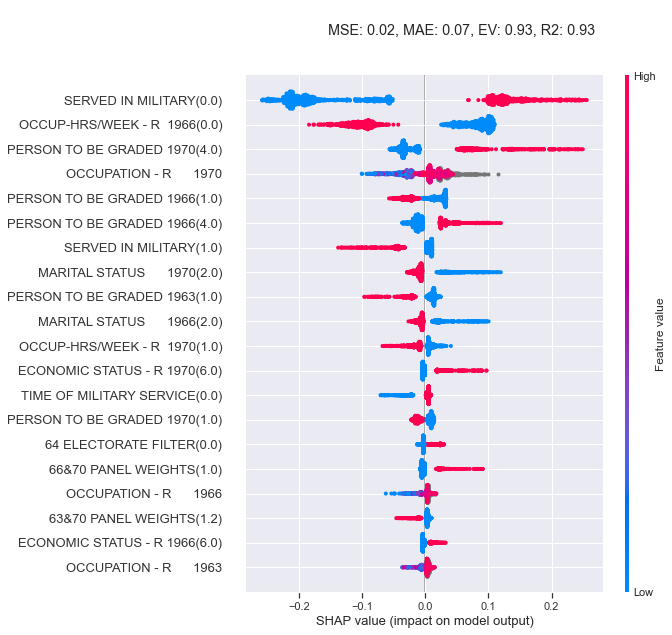

In [39]:
ge="1970"
generic_cols = f2f_harmonised.columns
# vote_complete = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"vote_complete"]
# f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"vote_complete"] = vote_complete.replace("OTH",np.nan).replace("PC",np.nan)

# con_lab = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"con-lab"]
mask = gender.isnull()

harm_vars = ["wt","age","housing_det","inc","inc_det","gender"]
target_var = "gender"
target_var_replace_dict = {}
target_var_drop_list = []
target_var_title_pair = None

var_stub = target_var
min_features = 20
drop_std_thresh = 0
drop_vars = [
    "v929","v930","v931","v932",
            'v545']
# specific_vars = ["v851","v852","v853","v854","v855","v856","v857a","v857b"]
# drop_vars = drop_vars+[k for k,v in BES_label_list[ge].items() if re.search("v7b|what would be your 2nd choice",v.lower())]

alg = get_xgboost_alg(classification_problem=False)

# find variables with no coverage/variation in focal instances (mask)
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=False)
# ,specific_vars=specific_vars
stds = df_pred[mask].std()
drop_vars = drop_vars + list(stds[stds.isnull()].index)+list(stds[stds<=drop_std_thresh].index)
drop_vars = [x for x in drop_vars if x not in ["wt",var_stub]]

(explainer, shap_values, train_columns, train_index, alg,output_subfolder) = prep_df(ge,target_var,target_var_replace_dict,
                                                                                     target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=False,drop_vars=drop_vars,demo_var_only=False,
                                                        alg=alg,multi_class_target=False)
# ,specific_vars=specific_vars

# setup df back up
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=False)
# use fitted algorithm to predict values
# vote_pred = pd.Series(alg.predict(df_pred[train_columns]),index=vote_complete.index)
# income_var_df_sm.loc[income_var_df_sm[ge].isnull(),ge] = pd.Series(inc_pred,index=income_var_df_sm[ge].index).apply(round)[income_var_df_sm[ge].isnull()]

In [57]:
gender_pred = pd.Series(alg.predict(df_pred[train_columns]),index=gender.index).round()

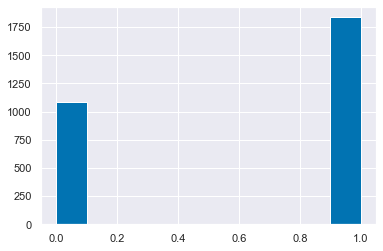

In [58]:
gender_pred.hist()

In [41]:
# {k:v for k,v in BES_label_list[ge].items() if "LOCAL ELECTION VOTE 1963" in v}

In [44]:

# f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender"]

0       0.0
1       1.0
2       1.0
3       0.0
4       0.0
       ... 
2917    1.0
2918    1.0
2919    1.0
2920    0.0
2921    1.0
Name: v932, Length: 2922, dtype: float64

In [62]:
gender.loc[gender.isnull()] = gender_pred.loc[gender.isnull()]
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender_complete"] = gender

In [63]:
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender_complete"].value_counts()

1.0    1582
0.0    1340
Name: gender_complete, dtype: int64

In [64]:
gender.value_counts()

1.0    1582
0.0    1340
Name: v932, dtype: int64

In [66]:
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1966","gender_complete"] = f2f_harmonised.loc[f2f_harmonised["dataset"]=="1970","gender_complete"]
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1964","gender_complete"] = f2f_harmonised.loc[f2f_harmonised["dataset"]=="1970","gender_complete"]
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1959","gender_complete"] = f2f_harmonised.loc[f2f_harmonised["dataset"]=="1970","gender_complete"]

f2f_harmonised.loc[f2f_harmonised["dataset"]=="1966","gender"] = f2f_harmonised.loc[f2f_harmonised["dataset"]=="1970","gender"]
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1964","gender"] = f2f_harmonised.loc[f2f_harmonised["dataset"]=="1970","gender"]
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1959","gender"] = f2f_harmonised.loc[f2f_harmonised["dataset"]=="1970","gender"]

In [ ]:
################################################


# 1974_feb

In [80]:
ge = "1974_feb"
{k:v for k,v in BES_label_list[ge].items() if "sex" in v}

{'feb199': 'sex of respondent'}

In [81]:
BES_df_list[ge]['feb199'].value_counts(dropna=False)

female    1293
male      1169
Name: feb199, dtype: int64

In [73]:
# male = 0, female = 1
gender = BES_df_list[ge]['feb199'].replace( {"male":0,"female":1} )

In [76]:
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","gender"] = gender
f2f_harmonised.loc[f2f_harmonised["dataset"]=="1974_feb","gender_complete"] = gender

MSE: 0.04, MAE: 0.09, EV: 0.85, R2: 0.85


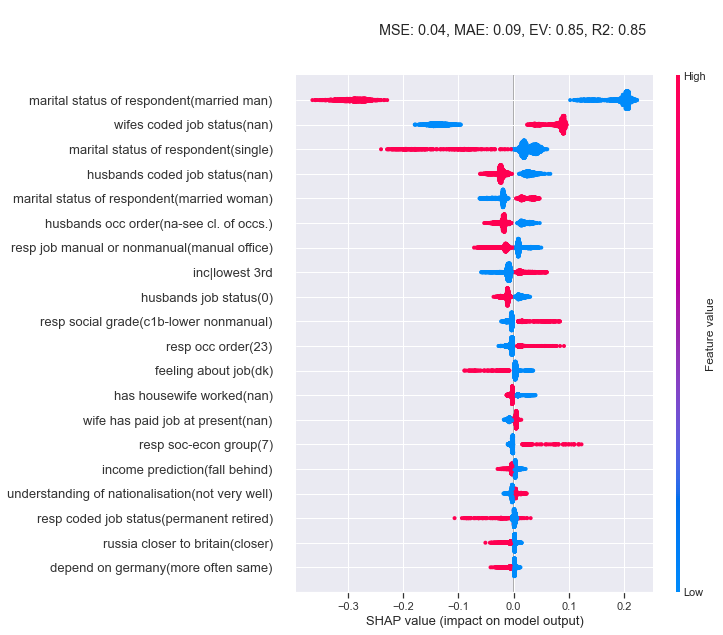

In [77]:
ge="1974_feb"
generic_cols = f2f_harmonised.columns
# vote_complete = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"vote_complete"]
# f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"vote_complete"] = vote_complete.replace("OTH",np.nan).replace("PC",np.nan)

# con_lab = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"con-lab"]
mask = gender.isnull()

harm_vars = ["wt","age","housing_det","inc","inc_det","gender"]
target_var = "gender"
target_var_replace_dict = {}
target_var_drop_list = []
target_var_title_pair = None

var_stub = target_var
min_features = 20
drop_std_thresh = 0
drop_vars = ['feb199']
# specific_vars = ["v851","v852","v853","v854","v855","v856","v857a","v857b"]
# drop_vars = drop_vars+[k for k,v in BES_label_list[ge].items() if re.search("v7b|what would be your 2nd choice",v.lower())]

alg = get_xgboost_alg(classification_problem=False)

# find variables with no coverage/variation in focal instances (mask)
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=False)
# ,specific_vars=specific_vars
stds = df_pred[mask].std()
drop_vars = drop_vars + list(stds[stds.isnull()].index)+list(stds[stds<=drop_std_thresh].index)
drop_vars = [x for x in drop_vars if x not in ["wt",var_stub]]

(explainer, shap_values, train_columns, train_index, alg,output_subfolder) = prep_df(ge,target_var,target_var_replace_dict,
                                                                                     target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=False,drop_vars=drop_vars,demo_var_only=False,
                                                        alg=alg,multi_class_target=False)
# ,specific_vars=specific_vars

# setup df back up
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=False)
# use fitted algorithm to predict values
gender_pred = pd.Series(alg.predict(df_pred[train_columns]),index=gender.index).round()
# income_var_df_sm.loc[income_var_df_sm[ge].isnull(),ge] = pd.Series(inc_pred,index=income_var_df_sm[ge].index).apply(round)[income_var_df_sm[ge].isnull()]

In [ ]:
#### 
# 1974_oct

In [89]:
ge = "1974_oct"
{k:v for k,v in BES_label_list[ge].items() if "sex" in v}

{'oct450': 'gone too far-sex equality', 'oct199': 'sex of respondent'}

In [90]:
BES_df_list[ge]['oct199'].value_counts(dropna=False)

female    1188
male      1177
Name: oct199, dtype: int64

In [91]:
# male = 0, female = 1
gender = BES_df_list[ge]['oct199'].replace( {"male":0,"female":1} )

f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender"] = gender
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender_complete"] = gender

MSE: 0.03, MAE: 0.08, EV: 0.87, R2: 0.87


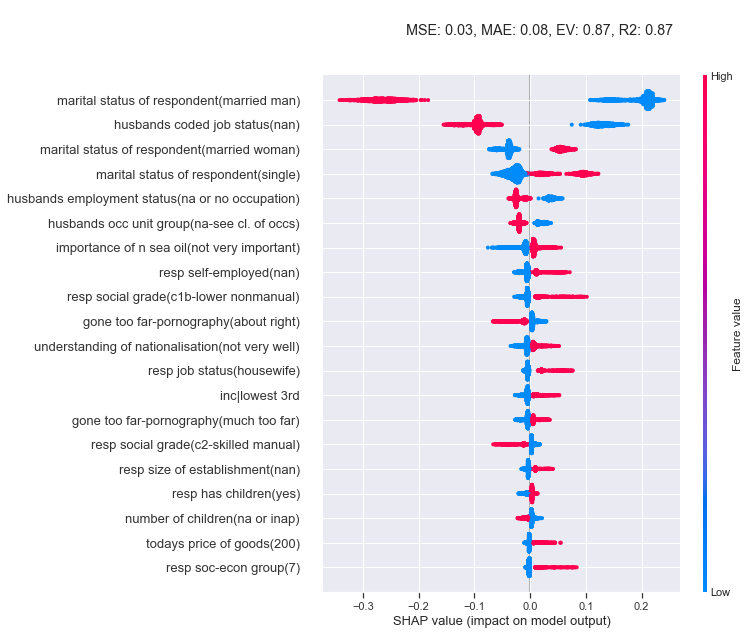

In [94]:
ge="1974_oct"
generic_cols = f2f_harmonised.columns
# vote_complete = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"vote_complete"]
# f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"vote_complete"] = vote_complete.replace("OTH",np.nan).replace("PC",np.nan)

# con_lab = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"con-lab"]
mask = gender.isnull()

harm_vars = ["wt","age","housing_det","inc","inc_det","gender"]
target_var = "gender"
target_var_replace_dict = {}
target_var_drop_list = []
target_var_title_pair = None

var_stub = target_var
min_features = 20
drop_std_thresh = 0
drop_vars = ['oct199']
# specific_vars = ["v851","v852","v853","v854","v855","v856","v857a","v857b"]
# drop_vars = drop_vars+[k for k,v in BES_label_list[ge].items() if re.search("v7b|what would be your 2nd choice",v.lower())]

alg = get_xgboost_alg(classification_problem=False)

# find variables with no coverage/variation in focal instances (mask)
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=False)
# ,specific_vars=specific_vars
stds = df_pred[mask].std()
drop_vars = drop_vars + list(stds[stds.isnull()].index)+list(stds[stds<=drop_std_thresh].index)
drop_vars = [x for x in drop_vars if x not in ["wt",var_stub]]

(explainer, shap_values, train_columns, train_index, alg,output_subfolder) = prep_df(ge,target_var,target_var_replace_dict,
                                                                                     target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=False,drop_vars=drop_vars,demo_var_only=False,
                                                        alg=alg,multi_class_target=False)
# ,specific_vars=specific_vars

# setup df back up
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=False)
# use fitted algorithm to predict values
gender_pred = pd.Series(alg.predict(df_pred[train_columns]),index=gender.index).round()
# income_var_df_sm.loc[income_var_df_sm[ge].isnull(),ge] = pd.Series(inc_pred,index=income_var_df_sm[ge].index).apply(round)[income_var_df_sm[ge].isnull()]

In [ ]:
#### 
# 1979

In [97]:
ge = "1979"
{k:v for k,v in BES_label_list[ge].items() if re.search("sex|gender", v)}

{'m450096': 'gone too far: sex equality-q26b', 'm199288': 'sex-q111'}

In [99]:
BES_df_list[ge]['m199288'].value_counts(dropna=False)

female    978
male      915
Name: m199288, dtype: int64

In [101]:
# male = 0, female = 1
gender = BES_df_list[ge]['m199288'].replace( {"male":0,"female":1} )

f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender"] = gender
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender_complete"] = gender

MSE: 0.07, MAE: 0.18, EV: 0.72, R2: 0.72


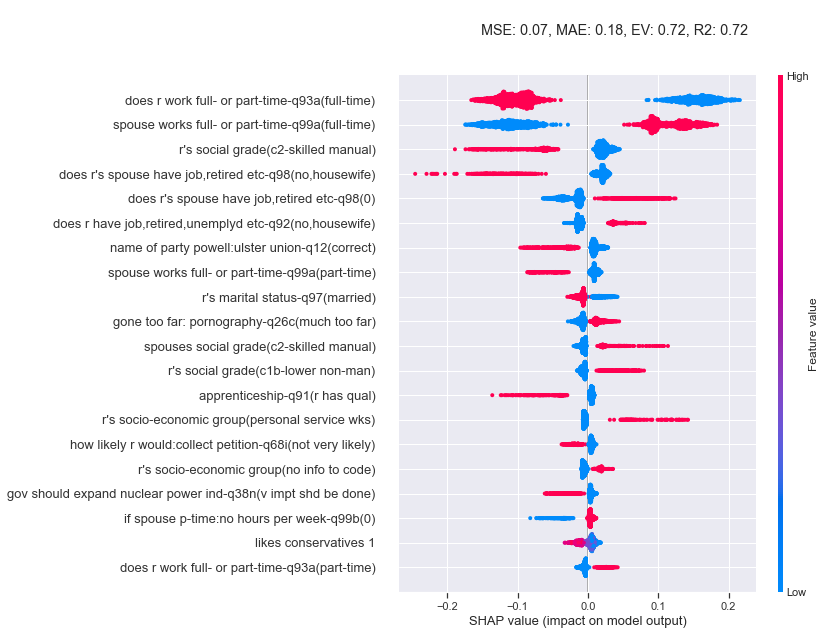

In [102]:
ge="1979"
generic_cols = f2f_harmonised.columns
# vote_complete = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"vote_complete"]
# f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"vote_complete"] = vote_complete.replace("OTH",np.nan).replace("PC",np.nan)

# con_lab = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"con-lab"]
mask = gender.isnull()

harm_vars = ["wt","age","housing_det","inc","inc_det","gender"]
target_var = "gender"
target_var_replace_dict = {}
target_var_drop_list = []
target_var_title_pair = None

var_stub = target_var
min_features = 20
drop_std_thresh = 0
drop_vars = ['m199288']
# specific_vars = ["v851","v852","v853","v854","v855","v856","v857a","v857b"]
# drop_vars = drop_vars+[k for k,v in BES_label_list[ge].items() if re.search("v7b|what would be your 2nd choice",v.lower())]

alg = get_xgboost_alg(classification_problem=False)

# find variables with no coverage/variation in focal instances (mask)
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=False)
# ,specific_vars=specific_vars
stds = df_pred[mask].std()
drop_vars = drop_vars + list(stds[stds.isnull()].index)+list(stds[stds<=drop_std_thresh].index)
drop_vars = [x for x in drop_vars if x not in ["wt",var_stub]]

(explainer, shap_values, train_columns, train_index, alg,output_subfolder) = prep_df(ge,target_var,target_var_replace_dict,
                                                                                     target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=False,drop_vars=drop_vars,demo_var_only=False,
                                                        alg=alg,multi_class_target=False)
# ,specific_vars=specific_vars

# setup df back up
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=False)
# use fitted algorithm to predict values
gender_pred = pd.Series(alg.predict(df_pred[train_columns]),index=gender.index).round()
# income_var_df_sm.loc[income_var_df_sm[ge].isnull(),ge] = pd.Series(inc_pred,index=income_var_df_sm[ge].index).apply(round)[income_var_df_sm[ge].isnull()]

In [ ]:
#### 
# 1983

In [103]:
ge = "1983"
{k:v for k,v in BES_label_list[ge].items() if re.search("sex|gender", v)}

{'q45c': 'gone too far: nudity and sex in media', 'q64b': "respondent's sex"}

In [104]:
BES_df_list[ge]['q64b'].value_counts(dropna=False)

female    2084
male      1871
Name: q64b, dtype: int64

In [105]:
# male = 0, female = 1
gender = BES_df_list[ge]['q64b'].replace( {"male":0,"female":1} )

f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender"] = gender
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender_complete"] = gender

MSE: 0.07, MAE: 0.19, EV: 0.70, R2: 0.70


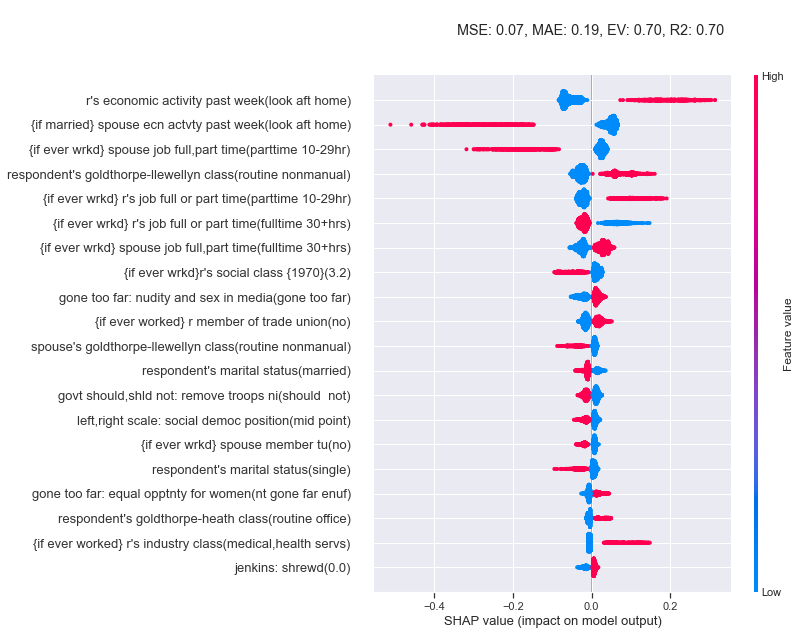

In [106]:
ge="1983"
generic_cols = f2f_harmonised.columns
# vote_complete = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"vote_complete"]
# f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"vote_complete"] = vote_complete.replace("OTH",np.nan).replace("PC",np.nan)

# con_lab = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"con-lab"]
mask = gender.isnull()

harm_vars = ["wt","age","housing_det","inc","inc_det","gender"]
target_var = "gender"
target_var_replace_dict = {}
target_var_drop_list = []
target_var_title_pair = None

var_stub = target_var
min_features = 20
drop_std_thresh = 0
drop_vars = ['q64b']
# specific_vars = ["v851","v852","v853","v854","v855","v856","v857a","v857b"]
# drop_vars = drop_vars+[k for k,v in BES_label_list[ge].items() if re.search("v7b|what would be your 2nd choice",v.lower())]

alg = get_xgboost_alg(classification_problem=False)

# find variables with no coverage/variation in focal instances (mask)
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=False)
# ,specific_vars=specific_vars
stds = df_pred[mask].std()
drop_vars = drop_vars + list(stds[stds.isnull()].index)+list(stds[stds<=drop_std_thresh].index)
drop_vars = [x for x in drop_vars if x not in ["wt",var_stub]]

(explainer, shap_values, train_columns, train_index, alg,output_subfolder) = prep_df(ge,target_var,target_var_replace_dict,
                                                                                     target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=False,drop_vars=drop_vars,demo_var_only=False,
                                                        alg=alg,multi_class_target=False)
# ,specific_vars=specific_vars

# setup df back up
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=False)
# use fitted algorithm to predict values
gender_pred = pd.Series(alg.predict(df_pred[train_columns]),index=gender.index).round()
# income_var_df_sm.loc[income_var_df_sm[ge].isnull(),ge] = pd.Series(inc_pred,index=income_var_df_sm[ge].index).apply(round)[income_var_df_sm[ge].isnull()]

In [ ]:
#### 
# 1987

In [114]:
ge = "1987"
{k:v for k,v in BES_label_list[ge].items() if re.search("sex|gender", v)}

{'varf1': 'info on unproductives: sex',
 'v43c': 'gone too far: right to show nudity/sex',
 'v43l': 'gone too far: equal opps homosexuals',
 'v58b': "resp's sex",
 'v123g': 'how much con look after interests of: homosexuals',
 'v124g': 'how much lab look after interests of: homosexuals',
 'v125g': 'how much alliance look after interests of: homosexuals'}

In [108]:
BES_df_list[ge]['v58b'].value_counts(dropna=False)

female    1990
male      1836
Name: v58b, dtype: int64

In [109]:
# male = 0, female = 1
gender = BES_df_list[ge]['v58b'].replace( {"male":0,"female":1} )

f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender"] = gender
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender_complete"] = gender

MSE: 0.08, MAE: 0.20, EV: 0.69, R2: 0.69


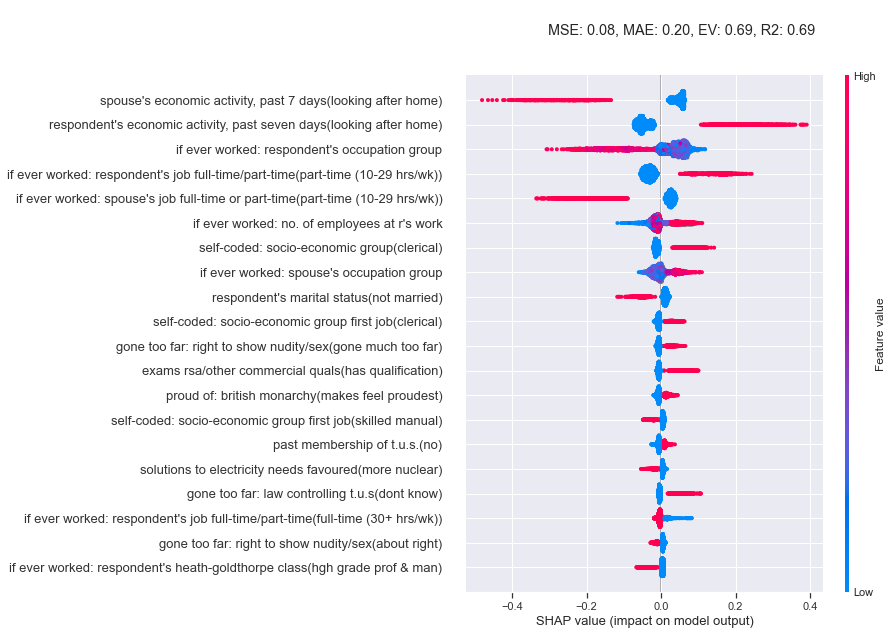

In [116]:
ge="1987"
generic_cols = f2f_harmonised.columns
# vote_complete = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"vote_complete"]
# f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"vote_complete"] = vote_complete.replace("OTH",np.nan).replace("PC",np.nan)

# con_lab = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"con-lab"]
mask = gender.isnull()

harm_vars = ["wt","age","housing_det","inc","inc_det","gender"]
target_var = "gender"
target_var_replace_dict = {}
target_var_drop_list = []
target_var_title_pair = None

var_stub = target_var
min_features = 20
drop_std_thresh = 0
drop_vars = ['v58b','varf1']
# specific_vars = ["v851","v852","v853","v854","v855","v856","v857a","v857b"]
# drop_vars = drop_vars+[k for k,v in BES_label_list[ge].items() if re.search("v7b|what would be your 2nd choice",v.lower())]

alg = get_xgboost_alg(classification_problem=False)

# find variables with no coverage/variation in focal instances (mask)
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=False)
# ,specific_vars=specific_vars
stds = df_pred[mask].std()
drop_vars = drop_vars + list(stds[stds.isnull()].index)+list(stds[stds<=drop_std_thresh].index)
drop_vars = [x for x in drop_vars if x not in ["wt",var_stub]]

(explainer, shap_values, train_columns, train_index, alg,output_subfolder) = prep_df(ge,target_var,target_var_replace_dict,
                                                                                     target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=False,drop_vars=drop_vars,demo_var_only=False,
                                                        alg=alg,multi_class_target=False)
# ,specific_vars=specific_vars

# setup df back up
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=False)
# use fitted algorithm to predict values
gender_pred = pd.Series(alg.predict(df_pred[train_columns]),index=gender.index).round()
# income_var_df_sm.loc[income_var_df_sm[ge].isnull(),ge] = pd.Series(inc_pred,index=income_var_df_sm[ge].index).apply(round)[income_var_df_sm[ge].isnull()]

In [127]:
#### 
# 1992
ge = "1992"

In [128]:
{k:v for k,v in BES_label_list[ge].items() if re.search("sex|gender", v)}

{'arf8b': "non-respondent's gender      [drop]arf8b",
 'v50h': 'equal opportunities to homosexuals? q50h',
 'v915b': "respondent's sex by observation    q915b",
 'v205d': 'homosexual relations always wrong? q205d',
 'rsexage': 'age within gender of respondent       dv'}

In [129]:
BES_df_list[ge]['v915b'].value_counts(dropna=False)

female    1884
male      1650
Name: v915b, dtype: int64

In [143]:
# male = 0, female = 1
gender = BES_df_list[ge]['v915b'].replace( {"male":0,"female":1} )

f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender"] = gender.astype('float')
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender_complete"] = gender.astype('float')

In [142]:
# f2f_harmonised["gender"] = f2f_harmonised["gender"].astype('float')
# f2f_harmonised["gender_complete"] = f2f_harmonised["gender_complete"].astype('float')

MSE: 0.09, MAE: 0.22, EV: 0.65, R2: 0.65


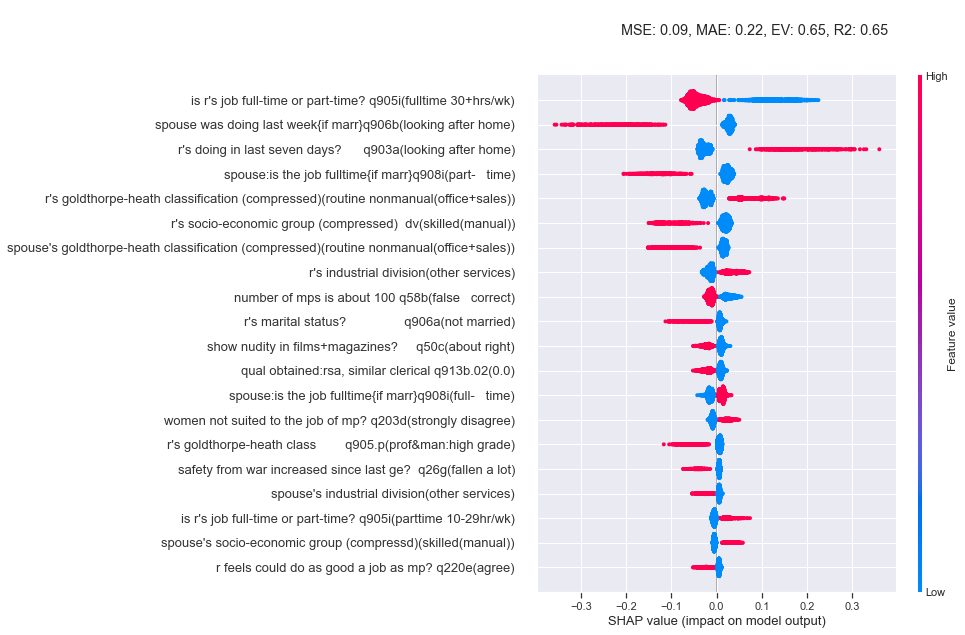

In [146]:
ge="1992"
generic_cols = f2f_harmonised.columns
# vote_complete = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"vote_complete"]
# f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"vote_complete"] = vote_complete.replace("OTH",np.nan).replace("PC",np.nan)

# con_lab = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"con-lab"]
mask = gender.isnull()

harm_vars = ["wt","age","housing_det","inc","inc_det","gender"]
target_var = "gender"
target_var_replace_dict = {}
target_var_drop_list = []
target_var_title_pair = None

var_stub = target_var
min_features = 20
drop_std_thresh = 0
drop_vars = ['v915b','rsexage']
# specific_vars = ["v851","v852","v853","v854","v855","v856","v857a","v857b"]
# drop_vars = drop_vars+[k for k,v in BES_label_list[ge].items() if re.search("v7b|what would be your 2nd choice",v.lower())]

alg = get_xgboost_alg(classification_problem=False)

# find variables with no coverage/variation in focal instances (mask)
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=False)
# ,specific_vars=specific_vars
stds = df_pred[mask].std()
drop_vars = drop_vars + list(stds[stds.isnull()].index)+list(stds[stds<=drop_std_thresh].index)
drop_vars = [x for x in drop_vars if x not in ["wt",var_stub]]

(explainer, shap_values, train_columns, train_index, alg,output_subfolder) = prep_df(ge,target_var,target_var_replace_dict,
                                                                                     target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=False,drop_vars=drop_vars,demo_var_only=False,
                                                        alg=alg,multi_class_target=False)
# ,specific_vars=specific_vars

# setup df back up
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=False)
# use fitted algorithm to predict values
gender_pred = pd.Series(alg.predict(df_pred[train_columns]),index=gender.index).round()
# income_var_df_sm.loc[income_var_df_sm[ge].isnull(),ge] = pd.Series(inc_pred,index=income_var_df_sm[ge].index).apply(round)[income_var_df_sm[ge].isnull()]

In [147]:
#### 
# 1997
ge = "1997"

In [148]:
{k:v for k,v in BES_label_list[ge].items() if re.search("sex|gender", v)}

{'intsex': 'sex of interviewer  q134',
 'sexnr': 'record sex of selected person q9 of q146',
 'rsex': "respondent's sex by observation  q628",
 'rsexage': 'age grouped within gender    dv q632',
 'gaysex': 'gay sexual relations always wrong  q204c',
 'cand1sex': 'candidate 1 remembered: sex inferred q218',
 'cand2sex': 'candidate 2 remembered: sex inferred q218',
 'cand3sex': 'candidate 3 remembered: sex inferred q218',
 'cand4sex': 'candidate 4 remembered: sex inferred q218',
 'cand5sex': 'candidate 5 remembered: sex inferred q218',
 'cand6sex': 'candidate 6 remembered: sex inferred q218'}

In [149]:
BES_df_list[ge]['rsex'].value_counts(dropna=False)

female    1966
male      1649
Name: rsex, dtype: int64

In [150]:
BES_df_list[ge]['sexnr'].value_counts(dropna=False)

female    1966
male      1649
Name: sexnr, dtype: int64

In [152]:
(BES_df_list[ge]['rsex']!=BES_df_list[ge]['sexnr'])

30

In [153]:
# male = 0, female = 1
gender = BES_df_list[ge]['rsex'].replace( {"male":0,"female":1} )
gender.loc[(BES_df_list[ge]['rsex']!=BES_df_list[ge]['sexnr'])]=np.nan

f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender"] = gender.astype('float')
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender_complete"] = gender.astype('float')

MSE: 0.09, MAE: 0.23, EV: 0.63, R2: 0.63


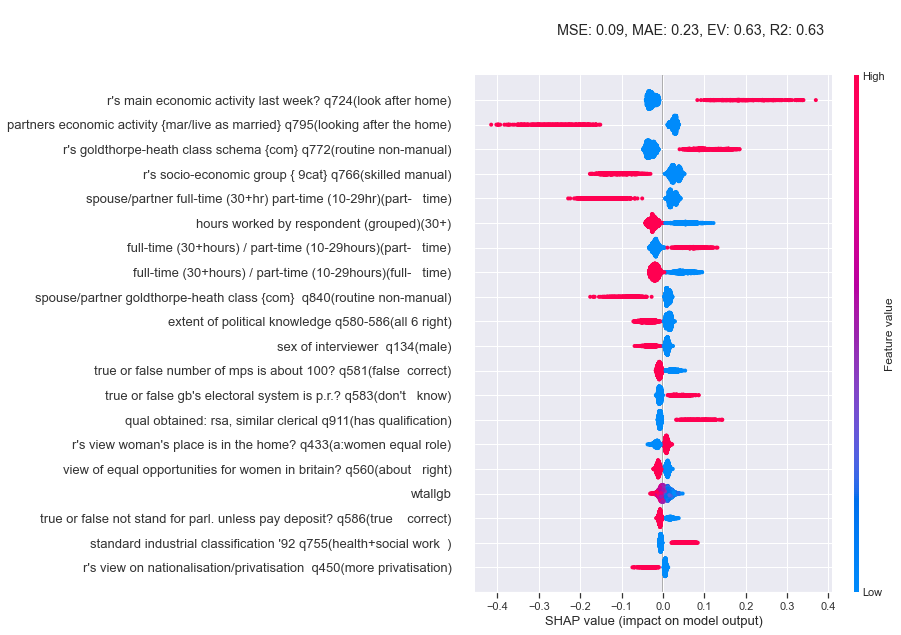

In [161]:
ge="1997"
generic_cols = f2f_harmonised.columns
# vote_complete = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"vote_complete"]
# f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"vote_complete"] = vote_complete.replace("OTH",np.nan).replace("PC",np.nan)

# con_lab = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"con-lab"]
mask = gender.isnull()

harm_vars = ["wt","age","housing_det","inc","inc_det","gender"]
target_var = "gender"
target_var_replace_dict = {}
target_var_drop_list = []
target_var_title_pair = None

var_stub = target_var
min_features = 20
drop_std_thresh = 0
drop_vars = ['rsex','rsexage','sexnr']
# specific_vars = ["v851","v852","v853","v854","v855","v856","v857a","v857b"]
# drop_vars = drop_vars+[k for k,v in BES_label_list[ge].items() if re.search("v7b|what would be your 2nd choice",v.lower())]

alg = get_xgboost_alg(classification_problem=False)

# find variables with no coverage/variation in focal instances (mask)
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=False)
# ,specific_vars=specific_vars
stds = df_pred[mask].std()
drop_vars = drop_vars + list(stds[stds.isnull()].index)+list(stds[stds<=drop_std_thresh].index)
drop_vars = [x for x in drop_vars if x not in ["wt",var_stub]]

(explainer, shap_values, train_columns, train_index, alg,output_subfolder) = prep_df(ge,target_var,target_var_replace_dict,
                                                                                     target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=False,drop_vars=drop_vars,demo_var_only=False,
                                                        alg=alg,multi_class_target=False)
# ,specific_vars=specific_vars

# setup df back up
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=False)
# use fitted algorithm to predict values
gender_pred = pd.Series(alg.predict(df_pred[train_columns]),index=gender.index).round()
# income_var_df_sm.loc[income_var_df_sm[ge].isnull(),ge] = pd.Series(inc_pred,index=income_var_df_sm[ge].index).apply(round)[income_var_df_sm[ge].isnull()]

In [162]:
gender.loc[gender.isnull()] = gender_pred.loc[gender.isnull()]
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender_complete"] = gender.astype('float')

In [164]:
#### 
# 2001
ge = "2001"
{k:v for k,v in BES_label_list[ge].items() if re.search("sex|gender", v)}

{'labsex01': 'gender of labour candidate',
 'consex01': 'gender of conservative candidate',
 'ldsex01': 'gender of ld candidate',
 'consex97': 'gender of conservative ppc',
 'labsex97': 'gender of labour ppc',
 'ldsex97': 'gender of lib dem ppc',
 'natsex97': 'gender of snp/pc ppc',
 'agender': 'gender',
 'agewgthc': 'hdc - age within gender weight',
 'genwgthc': 'hdc - gender weight',
 'awgtgb': 'region x gender x age w/ gender weight',
 'bq104': 'gender(2nd)',
 'bagewgt': 'panel weight-age w/gender',
 'bgenwgt': 'panel weight-gender',
 'bpanwgt': 'panel weight-gender x age w/gender x region',
 'genall': 'gender-all respondents',
 'genoctwt': 'gender weight-post-election respondents',
 'ageoctmw': 'age w/ gender weight-post-election respondents',
 'postoctw': 'post-election x-sect weight-region*gender*age w/gender',
 'mgenwgt': 'mailback-gender weight',
 'magewgt': 'mailback-age w/gender weight',
 'mailwgt': 'mailback-region*gender*age w/gender weight'}

In [165]:
BES_df_list[ge]['genall'].value_counts(dropna=False)

female          1683
male            1346
not recorded       1
Name: genall, dtype: int64

In [166]:
BES_df_list[ge]['agender'].value_counts(dropna=False)

female          1309
male            1039
NaN              681
not recorded       1
Name: agender, dtype: int64

In [168]:
BES_df_list[ge]['bq104'].value_counts(dropna=False)

female          1680
male            1350
not recorded       0
not app            0
Name: bq104, dtype: int64

In [179]:
# male = 0, female = 1
gender = BES_df_list[ge]['genall'].replace( {"male":0,"female":1,'not recorded':np.nan,'not app':np.nan} )
gender.loc[gender!=BES_df_list[ge]['bq104'].replace( {"male":0,"female":1,'not recorded':np.nan,'not app':np.nan})]=np.nan
gender.loc[(gender!=BES_df_list[ge]['agender'].replace( {"male":0,"female":1,'not recorded':np.nan,'not app':np.nan}))&BES_df_list[ge]['agender'].notnull()]=np.nan
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender"] = gender.astype('float')
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender_complete"] = gender.astype('float')

In [178]:
gender.value_counts(dropna=False)

1.0    1680
0.0    1346
NaN       4
Name: genall, dtype: int64

MSE: 0.13, MAE: 0.30, EV: 0.47, R2: 0.47


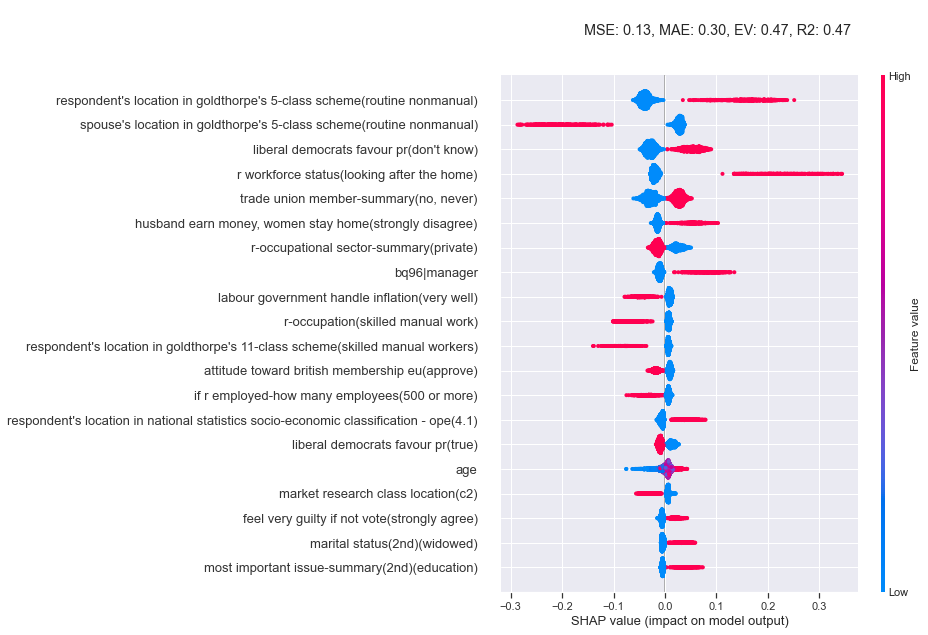

In [180]:
ge="2001"
generic_cols = f2f_harmonised.columns
# vote_complete = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"vote_complete"]
# f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"vote_complete"] = vote_complete.replace("OTH",np.nan).replace("PC",np.nan)

# con_lab = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"con-lab"]
mask = gender.isnull()

harm_vars = ["wt","age","housing_det","inc","inc_det","gender"]
target_var = "gender"
target_var_replace_dict = {}
target_var_drop_list = []
target_var_title_pair = None

var_stub = target_var
min_features = 20
drop_std_thresh = 0
drop_vars = ['genall','bq104','agender','agewgthc','genwgthc','awgtgb','bagewgt','bgenwgt','bpanwgt','genoctwt',
            'ageoctmw','postoctw','mgenwgt','magewgt','mailwgt']
# specific_vars = ["v851","v852","v853","v854","v855","v856","v857a","v857b"]
# drop_vars = drop_vars+[k for k,v in BES_label_list[ge].items() if re.search("v7b|what would be your 2nd choice",v.lower())]



alg = get_xgboost_alg(classification_problem=False)

# find variables with no coverage/variation in focal instances (mask)
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=False)
# ,specific_vars=specific_vars
stds = df_pred[mask].std()
drop_vars = drop_vars + list(stds[stds.isnull()].index)+list(stds[stds<=drop_std_thresh].index)
drop_vars = [x for x in drop_vars if x not in ["wt",var_stub]]

(explainer, shap_values, train_columns, train_index, alg,output_subfolder) = prep_df(ge,target_var,target_var_replace_dict,
                                                                                     target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=False,drop_vars=drop_vars,demo_var_only=False,
                                                        alg=alg,multi_class_target=False)
# ,specific_vars=specific_vars

# setup df back up
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=False)
# use fitted algorithm to predict values
gender_pred = pd.Series(alg.predict(df_pred[train_columns]),index=gender.index).round()
# income_var_df_sm.loc[income_var_df_sm[ge].isnull(),ge] = pd.Series(inc_pred,index=income_var_df_sm[ge].index).apply(round)[income_var_df_sm[ge].isnull()]

In [181]:
gender.loc[gender.isnull()] = gender_pred.loc[gender.isnull()]
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender_complete"] = gender.astype('float')

In [182]:
#### 
# 2005
ge = "2005"
{k:v for k,v in BES_label_list[ge].items() if re.search("sex|gender", v)}

{'aq69': "r's gender",
 'bq76': 'gender',
 'tq76': 'combined gender',
 'cgender': "r's gender(3rd)",
 'consex05': 'gender of consevative ppc 2005',
 'labsex05': 'gender of labour ppc 2005',
 'ldsex05': 'gender of liberal democrat ppc 2005',
 'consex01': 'gender of conservative candidate 2001',
 'labsex01': 'gender of labour candidate 2001',
 'ldsex01': 'gender of ld candidate 2001',
 'consex97': 'gender of conservative ppc',
 'ldsex97': 'gender of lib dem ppc',
 'labsex97': 'gender of labour ppc',
 'natsex97': 'gender of snp/pc ppc',
 'dq66': 'gender(3rd)'}

In [183]:
BES_df_list[ge]['tq76'].value_counts(dropna=False)
# 1 Male
# 2 Female

2.0    2318
1.0    1839
NaN       4
Name: tq76, dtype: int64

In [187]:
BES_df_list[ge][['tq76','aq69','bq76','cgender','dq66']].stack().value_counts()

2.0     8546
1.0     6855
9.0     1235
99.0     935
dtype: int64

In [193]:
gender_inconsistent = BES_df_list[ge][['tq76','aq69','bq76','cgender','dq66']].replace({2:1,1:0,99:np.nan,9:np.nan}).apply(lambda x: len(x.dropna().unique()),axis=1)>=2
gender_inconsistent.sum()

68

In [194]:
# male = 0, female = 1
gender = BES_df_list[ge]['tq76'].replace( {1:0,2:1,99:np.nan,9:np.nan} )
gender.loc[gender_inconsistent]=np.nan

f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender"] = gender.astype('float')
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender_complete"] = gender.astype('float')

MSE: 0.09, MAE: 0.23, EV: 0.64, R2: 0.64


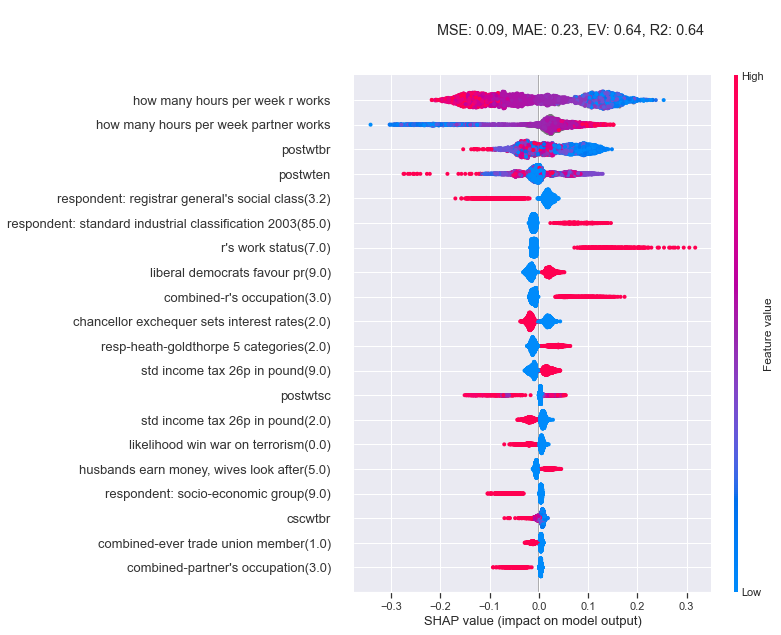

In [195]:
ge="2005"
generic_cols = f2f_harmonised.columns
# vote_complete = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"vote_complete"]
# f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"vote_complete"] = vote_complete.replace("OTH",np.nan).replace("PC",np.nan)

# con_lab = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"con-lab"]
mask = gender.isnull()

harm_vars = ["wt","age","housing_det","inc","inc_det","gender"]
target_var = "gender"
target_var_replace_dict = {}
target_var_drop_list = []
target_var_title_pair = None

var_stub = target_var
min_features = 20
drop_std_thresh = 0
drop_vars = ['tq76','aq69','bq76','cgender','dq66']
# specific_vars = ["v851","v852","v853","v854","v855","v856","v857a","v857b"]
# drop_vars = drop_vars+[k for k,v in BES_label_list[ge].items() if re.search("v7b|what would be your 2nd choice",v.lower())]



alg = get_xgboost_alg(classification_problem=False)

# find variables with no coverage/variation in focal instances (mask)
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=False)
# ,specific_vars=specific_vars
stds = df_pred[mask].std()
drop_vars = drop_vars + list(stds[stds.isnull()].index)+list(stds[stds<=drop_std_thresh].index)
drop_vars = [x for x in drop_vars if x not in ["wt",var_stub]]

(explainer, shap_values, train_columns, train_index, alg,output_subfolder) = prep_df(ge,target_var,target_var_replace_dict,
                                                                                     target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=False,drop_vars=drop_vars,demo_var_only=False,
                                                        alg=alg,multi_class_target=False)
# ,specific_vars=specific_vars

# setup df back up
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=False)
# use fitted algorithm to predict values
gender_pred = pd.Series(alg.predict(df_pred[train_columns]),index=gender.index).round()
# income_var_df_sm.loc[income_var_df_sm[ge].isnull(),ge] = pd.Series(inc_pred,index=income_var_df_sm[ge].index).apply(round)[income_var_df_sm[ge].isnull()]

In [196]:
gender.loc[gender.isnull()] = gender_pred.loc[gender.isnull()]
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender_complete"] = gender.astype('float')

In [197]:
#### 
# 2010
ge = "2010"
{k:v for k,v in BES_label_list[ge].items() if re.search("sex|gender", v)}

{'aq62': 'gender',
 'bq88': 'gender(3rd)',
 'consex10': 'sex of the conservative ppc 2010',
 'labsex10': 'sex of the labour ppc 2010',
 'ldsex10': 'sex of the liberal democrat ppc 2010',
 'cq41': 'gender(4th)',
 'zq88': 'gender(5th)'}

In [201]:
BES_df_list[ge]['zq88'].value_counts(dropna=False)
# 1 Male
# 2 Female

female    1655
male      1420
Name: zq88, dtype: int64

In [202]:
BES_df_list[ge]['bq88'].value_counts(dropna=False)

female    1655
male      1420
Name: bq88, dtype: int64

In [207]:
gender_inconsistent = BES_df_list[ge][['aq62','bq88','cq41','zq88']].apply(lambda x: len(x.dropna().unique()),axis=1)>=2

In [208]:
gender_inconsistent.sum()

47

In [210]:
(BES_df_list[ge]['bq88']!=BES_df_list[ge]['zq88']).sum()

0

In [211]:
# male = 0, female = 1
gender = BES_df_list[ge]['bq88'].replace( {"male":0,"female":1} )
gender.loc[gender_inconsistent]=np.nan

f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender"] = gender.astype('float')
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender_complete"] = gender.astype('float')

MSE: 0.15, MAE: 0.33, EV: 0.41, R2: 0.41


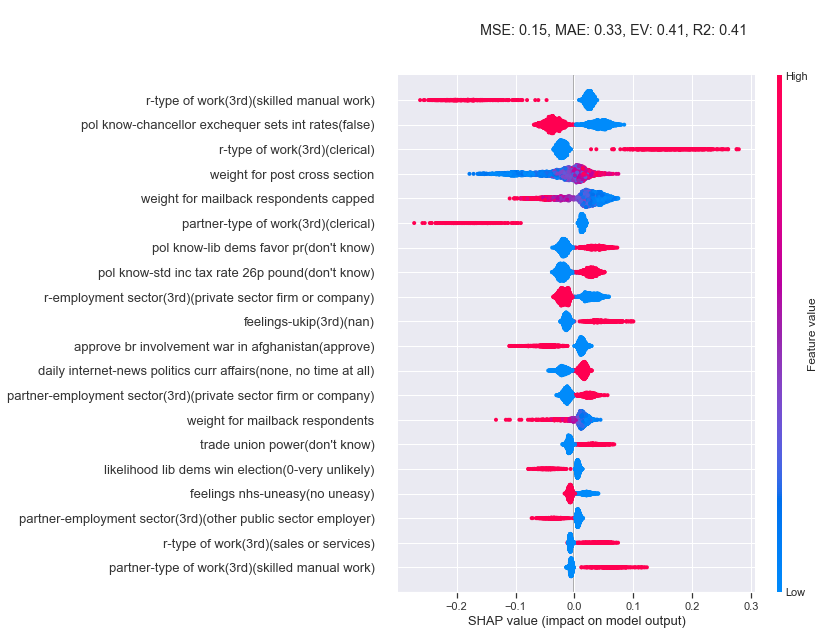

In [213]:
ge="2010"
generic_cols = f2f_harmonised.columns
# vote_complete = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"vote_complete"]
# f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"vote_complete"] = vote_complete.replace("OTH",np.nan).replace("PC",np.nan)

# con_lab = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"con-lab"]
mask = gender.isnull()

harm_vars = ["wt","age","housing_det","inc","inc_det","gender"]
target_var = "gender"
target_var_replace_dict = {}
target_var_drop_list = []
target_var_title_pair = None

var_stub = target_var
min_features = 20
drop_std_thresh = 0
drop_vars = ['aq62','bq88','cq41','zq88','asexage']
# specific_vars = ["v851","v852","v853","v854","v855","v856","v857a","v857b"]
# drop_vars = drop_vars+[k for k,v in BES_label_list[ge].items() if re.search("v7b|what would be your 2nd choice",v.lower())]



alg = get_xgboost_alg(classification_problem=False)

# find variables with no coverage/variation in focal instances (mask)
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=False)
# ,specific_vars=specific_vars
stds = df_pred[mask].std()
drop_vars = drop_vars + list(stds[stds.isnull()].index)+list(stds[stds<=drop_std_thresh].index)
drop_vars = [x for x in drop_vars if x not in ["wt",var_stub]]

(explainer, shap_values, train_columns, train_index, alg,output_subfolder) = prep_df(ge,target_var,target_var_replace_dict,
                                                                                     target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=False,drop_vars=drop_vars,demo_var_only=False,
                                                        alg=alg,multi_class_target=False)
# ,specific_vars=specific_vars

# setup df back up
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=False)
# use fitted algorithm to predict values
gender_pred = pd.Series(alg.predict(df_pred[train_columns]),index=gender.index).round()
# income_var_df_sm.loc[income_var_df_sm[ge].isnull(),ge] = pd.Series(inc_pred,index=income_var_df_sm[ge].index).apply(round)[income_var_df_sm[ge].isnull()]

In [214]:
gender.loc[gender.isnull()] = gender_pred.loc[gender.isnull()]
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender_complete"] = gender.astype('float')

In [220]:
#### 
# 2015
ge = "2015"
{k:v for k,v in BES_label_list[ge].items() if re.search("sex|gender", v.lower())}

{'y09': 'Gender'}

In [221]:
BES_df_list[ge]['y09'].value_counts(dropna=False)

Female    1615
Male      1372
Name: y09, dtype: int64

In [222]:
# male = 0, female = 1
gender = BES_df_list[ge]['y09'].replace( {"Male":0,"Female":1} )

f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender"] = gender.astype('float')
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender_complete"] = gender.astype('float')

MSE: 0.17, MAE: 0.36, EV: 0.32, R2: 0.32


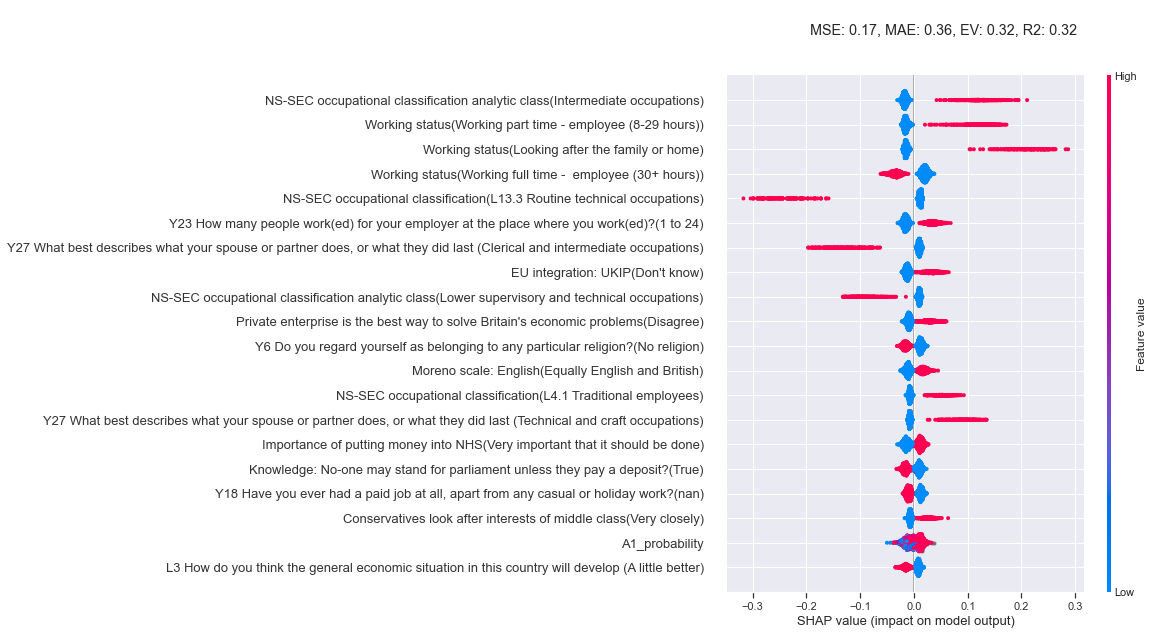

In [223]:
ge="2015"
generic_cols = f2f_harmonised.columns
# vote_complete = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"vote_complete"]
# f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"vote_complete"] = vote_complete.replace("OTH",np.nan).replace("PC",np.nan)

# con_lab = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"con-lab"]
mask = gender.isnull()

harm_vars = ["wt","age","housing_det","inc","inc_det","gender"]
target_var = "gender"
target_var_replace_dict = {}
target_var_drop_list = []
target_var_title_pair = None

var_stub = target_var
min_features = 20
drop_std_thresh = 0
drop_vars = ['y09']
# specific_vars = ["v851","v852","v853","v854","v855","v856","v857a","v857b"]
# drop_vars = drop_vars+[k for k,v in BES_label_list[ge].items() if re.search("v7b|what would be your 2nd choice",v.lower())]



alg = get_xgboost_alg(classification_problem=False)

# find variables with no coverage/variation in focal instances (mask)
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=False)
# ,specific_vars=specific_vars
stds = df_pred[mask].std()
drop_vars = drop_vars + list(stds[stds.isnull()].index)+list(stds[stds<=drop_std_thresh].index)
drop_vars = [x for x in drop_vars if x not in ["wt",var_stub]]

(explainer, shap_values, train_columns, train_index, alg,output_subfolder) = prep_df(ge,target_var,target_var_replace_dict,
                                                                                     target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=False,drop_vars=drop_vars,demo_var_only=False,
                                                        alg=alg,multi_class_target=False)
# ,specific_vars=specific_vars

# setup df back up
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=False)
# use fitted algorithm to predict values
gender_pred = pd.Series(alg.predict(df_pred[train_columns]),index=gender.index).round()
# income_var_df_sm.loc[income_var_df_sm[ge].isnull(),ge] = pd.Series(inc_pred,index=income_var_df_sm[ge].index).apply(round)[income_var_df_sm[ge].isnull()]

In [224]:
gender.loc[gender.isnull()] = gender_pred.loc[gender.isnull()]
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender_complete"] = gender.astype('float')

In [260]:
#### 
# 2017
ge = "2017"
{k:v for k,v in BES_label_list[ge].items() if re.search("sex|gender", v.lower())}

{'y09': 'Gender', 'q24_cses': 'CSES: Gender'}

In [261]:
gender = BES_df_list[ge]["y09"]
gender.value_counts(dropna=False)

Female    1193
Male      1001
Name: y09, dtype: int64

In [262]:
cses_gender = BES_df_list[ge]["q24_cses"].replace("Not stated",np.nan)
cses_gender.value_counts(dropna=False)

NaN       1218
Female     566
Male       410
Name: q24_cses, dtype: int64

In [263]:
gender_inconsistent = cses_gender[(gender!=cses_gender)&cses_gender.notnull()].index
# male = 0, female = 1
gender = gender.replace( {"Male":0,"Female":1} )
gender.loc[gender_inconsistent] = np.nan
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender"] = gender.astype('float')
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender_complete"] = gender.astype('float')

MSE: 0.16, MAE: 0.34, EV: 0.33, R2: 0.33


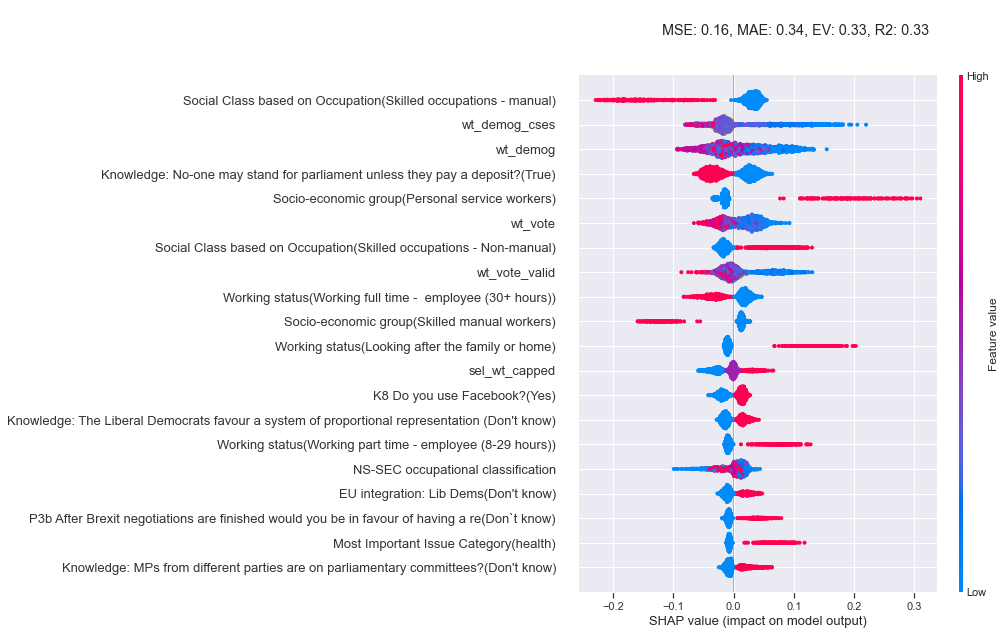

In [264]:
ge="2017"
generic_cols = f2f_harmonised.columns
# vote_complete = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"vote_complete"]
# f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"vote_complete"] = vote_complete.replace("OTH",np.nan).replace("PC",np.nan)

# con_lab = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"con-lab"]
mask = gender.isnull()

harm_vars = ["wt","age","housing_det","inc","inc_det","gender"]
target_var = "gender"
target_var_replace_dict = {}
target_var_drop_list = []
target_var_title_pair = None

var_stub = target_var
min_features = 20
drop_std_thresh = 0
drop_vars = ['y09','q24_cses']
# specific_vars = ["v851","v852","v853","v854","v855","v856","v857a","v857b"]
# drop_vars = drop_vars+[k for k,v in BES_label_list[ge].items() if re.search("v7b|what would be your 2nd choice",v.lower())]



alg = get_xgboost_alg(classification_problem=False)

# find variables with no coverage/variation in focal instances (mask)
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=False)
# ,specific_vars=specific_vars
stds = df_pred[mask].std()
drop_vars = drop_vars + list(stds[stds.isnull()].index)+list(stds[stds<=drop_std_thresh].index)
drop_vars = [x for x in drop_vars if x not in ["wt",var_stub]]

(explainer, shap_values, train_columns, train_index, alg,output_subfolder) = prep_df(ge,target_var,target_var_replace_dict,
                                                                                     target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=False,drop_vars=drop_vars,demo_var_only=False,
                                                        alg=alg,multi_class_target=False)
# ,specific_vars=specific_vars

# setup df back up
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=False)
# use fitted algorithm to predict values
gender_pred = pd.Series(alg.predict(df_pred[train_columns]),index=gender.index).round()
# income_var_df_sm.loc[income_var_df_sm[ge].isnull(),ge] = pd.Series(inc_pred,index=income_var_df_sm[ge].index).apply(round)[income_var_df_sm[ge].isnull()]

In [265]:
gender.loc[gender.isnull()] = gender_pred.loc[gender.isnull()]
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender_complete"] = gender.astype('float')

In [266]:
#### 
# 2019
ge = "2019"
{k:v for k,v in BES_label_list[ge].items() if re.search("sex|gender", v.lower())}

{'y09': 'Gender',
 'y27': 'Which of the following best describes your sexuality?',
 'Q23_CSES': 'Gender(cses)'}

In [267]:
gender = BES_df_list[ge]["y09"].replace({"Prefer not to say":np.nan,"In another way":np.nan,"Not stated":np.nan})
gender.value_counts(dropna=False)

Female    2100
Male      1809
NaN         37
Name: y09, dtype: int64

In [268]:
cses_gender = BES_df_list[ge]["Q23_CSES"].replace("Prefer not to say",np.nan)
cses_gender.value_counts(dropna=False)

NaN       2765
Female     647
Male       534
Name: Q23_CSES, dtype: int64

In [ ]:
## bit filthy given that in 2019 people/categories are clearly allowing for variants of "neither"
## but I think justifiable as part of 1964-2019 series

In [269]:
gender_inconsistent = cses_gender[(gender!=cses_gender)&cses_gender.notnull()].index
# male = 0, female = 1
gender = gender.replace( {"Male":0,"Female":1} )
gender.loc[gender_inconsistent] = np.nan
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender"] = gender.astype('float')
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender_complete"] = gender.astype('float')

MSE: 0.15, MAE: 0.33, EV: 0.40, R2: 0.40


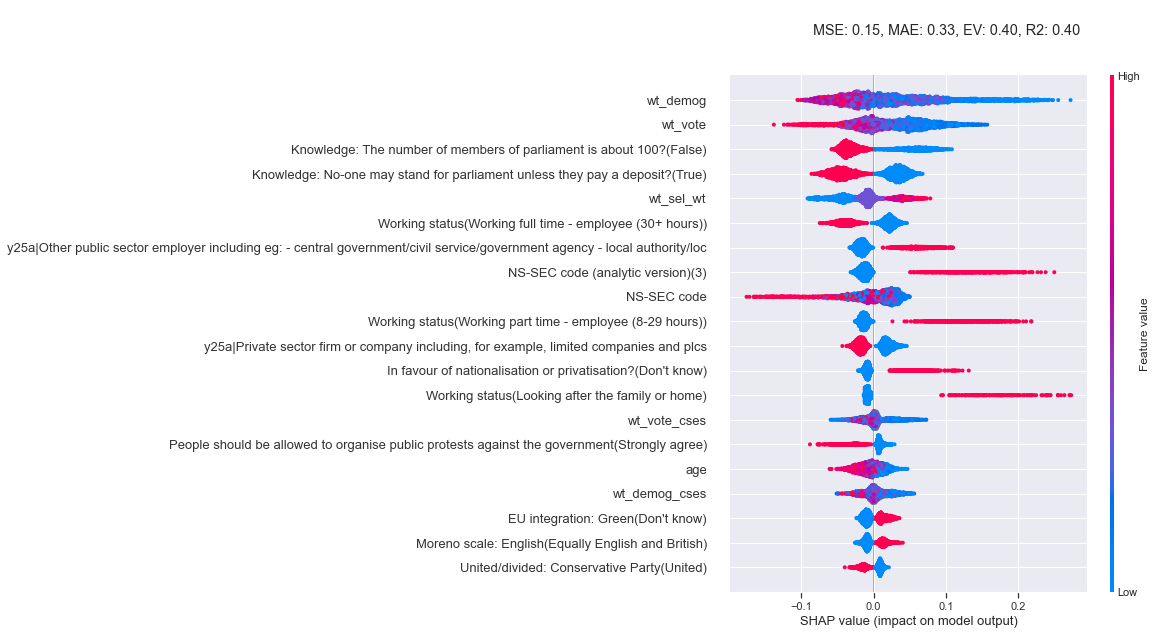

In [270]:
ge="2019"
generic_cols = f2f_harmonised.columns
# vote_complete = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"vote_complete"]
# f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"vote_complete"] = vote_complete.replace("OTH",np.nan).replace("PC",np.nan)

# con_lab = f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"con-lab"]
mask = gender.isnull()

harm_vars = ["wt","age","housing_det","inc","inc_det","gender"]
target_var = "gender"
target_var_replace_dict = {}
target_var_drop_list = []
target_var_title_pair = None

var_stub = target_var
min_features = 20
drop_std_thresh = 0
drop_vars = ['y09','Q23_CSES']
# specific_vars = ["v851","v852","v853","v854","v855","v856","v857a","v857b"]
# drop_vars = drop_vars+[k for k,v in BES_label_list[ge].items() if re.search("v7b|what would be your 2nd choice",v.lower())]



alg = get_xgboost_alg(classification_problem=False)

# find variables with no coverage/variation in focal instances (mask)
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=False)
# ,specific_vars=specific_vars
stds = df_pred[mask].std()
drop_vars = drop_vars + list(stds[stds.isnull()].index)+list(stds[stds<=drop_std_thresh].index)
drop_vars = [x for x in drop_vars if x not in ["wt",var_stub]]

(explainer, shap_values, train_columns, train_index, alg,output_subfolder) = prep_df(ge,target_var,target_var_replace_dict,
                                                                                     target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=False,drop_vars=drop_vars,demo_var_only=False,
                                                        alg=alg,multi_class_target=False)
# ,specific_vars=specific_vars

# setup df back up
df_pred = prep_df_only(ge,target_var,target_var_replace_dict,target_var_drop_list,target_var_title_pair,
       var_stub,harm_vars,min_features,dependence_plots=True,drop_vars=drop_vars,demo_var_only=False)
# use fitted algorithm to predict values
gender_pred = pd.Series(alg.predict(df_pred[train_columns]),index=gender.index).round()
# income_var_df_sm.loc[income_var_df_sm[ge].isnull(),ge] = pd.Series(inc_pred,index=income_var_df_sm[ge].index).apply(round)[income_var_df_sm[ge].isnull()]

In [271]:
gender.loc[gender.isnull()] = gender_pred.loc[gender.isnull()]
f2f_harmonised.loc[f2f_harmonised["dataset"]==ge,"gender_complete"] = gender.astype('float')

In [274]:
f2f_harmonised["gender_complete"].value_counts(dropna=False)

1.0    28316
0.0    24415
Name: gender_complete, dtype: int64

In [275]:
f2f_harmonised["gender"].value_counts(dropna=False)

1.0    28080
0.0    24297
NaN      354
Name: gender, dtype: int64

In [ ]:
# BES_df_list = pickle.load( open( "E:\\BES_analysis_data\\Face_to_face\\BES_df_list.pickle", "rb" ) )
# f2f_harmonised = pd.read_pickle("E:\\BES_analysis_data\\Face_to_face\\f2f_harmonised.zip", compression='zip')
# BES_label_list = pickle.load( open( "E:\\BES_analysis_data\\Face_to_face\\BES_label_list.pickle", "rb" ) )
# demo_var_dict = pickle.load( open( "E:\\BES_analysis_data\\Face_to_face\\demo_var_dict.pickle", "rb" ) )
# var_type_dict_nonans = pickle.load( open( "E:\\BES_analysis_data\\Face_to_face\\var_type_dict_nonans.pickle", "rb" ) )

In [276]:
f2f_harmonised.to_pickle("E:\\BES_analysis_data\\Face_to_face\\f2f_harmonised.zip", compression='zip')
pickle.dump( BES_label_list, open( "E:\\BES_analysis_data\\Face_to_face\\BES_label_list.pickle", "wb" ) )
pickle.dump( BES_df_list, open( "E:\\BES_analysis_data\\Face_to_face\\BES_df_list.pickle", "wb" ) )

pickle.dump( demo_var_dict, open( "E:\\BES_analysis_data\\Face_to_face\\demo_var_dict.pickle", "wb") )
pickle.dump( var_type_dict_nonans, open( "E:\\BES_analysis_data\\Face_to_face\\var_type_dict_nonans.pickle", "wb") )
